# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал, вмете с новыми фиками добавил количество поисков на последний месяц и неделю. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные значения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

7) Кластеризация. Очень долго ей занимался, сейчас подведу итоги всех трех дней. Главная идея такая - модель уже использует агригаты, так что для того чтобы повысить качество нужно использовать какую то иную информацию. Первое что проходит на ум - запросы человека. Банально провести кластеризацию на запросах и потом построить на этих метках новые агрегаты. Но есть проблема, у нас 77кк строк запросов и даже если написать нормальный алгоритм это будет работать 19 часов. Помимо того на сэмпле и понижении размерности через PCA выяснилось, что данные это полосы, крупные классы запиывают мелкие и те забиваются одной неразделимой кучей в углу, не получается чегото адекватного даже если использовать гауссовскую кластеризациюд или GMM. 300к обьектов обрабатывались несколько минут и я решил сделать кластеризацию полуавтоматически. Я создал столбец 'cluster' и заполнил его -1. Построив кластеризацию на 10_000 обьектах выделил некоторые классы, они ясно выделаются, например 20-30 обьектов с словом "вода" в названии, и заполнил их метки руками. Потом снова построил кластеризацию на оставшихся. Леноточная структура осталась, но обьекты былит уже другими. за каждую такую итерацию отсеивалось от 3кк до 10кк обьектов. Итого у меня определилось 18 кластеров - напитки, питомцы, мясо и многое другое. В итоге еще осталось 23кк обьектов, но там очень сложно выделить группы. В принципе я могу свести их до 10кк, но вопрос есть ли в этом смысл. После таких не простых манипуляций мы получаем метки, но это просто инструмент. То что реально даст прирост качества это агрегаты. Не просто было придумать их и не все оказались удачными. Я добавил последний доминирующий кластер, концентрация интересов, переключения между кластерами, стабильность кластеров, время в основном кластере, среднее время между сменами кластеров, средняя длина запроса, разница длины запросов. В итоге скор получился 0.8221.

8) Итак, начинаем агрегацию через knn, начальный скор без поли фичей и кластеризации по поиску - 0.8208

--------------------------------------------

--------------------------------------------

In [146]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [148]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [149]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [150]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [151]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"
    )

In [152]:
# search_aggs
id_ = 4
suf = 'search'

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [153]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

num_cols = ['num_products_click', 'sum_discount_price_click', 'max_discount_price_click', 'days_since_last_click', 'days_since_first_click', 
    'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite', 'days_since_last_favorite', 
    'days_since_first_favorite', 'num_products_order', 'sum_discount_price_order', 'max_discount_price_order', 'days_since_last_order', 
    'days_since_first_order', 'num_products_to_cart', 'sum_discount_price_to_cart', 'max_discount_price_to_cart', 'days_since_last_to_cart', 
    'days_since_first_to_cart']

In [154]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
tr, val = get_split(df_pd, val_size=0.3)

cols = [
    # Существующие столбцы
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
]

In [155]:
df_pd

,user_id,target,num_products_click,sum_discount_price_click,max_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,num_products_favorite,...,days_since_last_to_cart,days_since_first_to_cart,num_search,unique_search_queries,num_search_last_month,num_search_last_week,days_since_last_search,days_since_first_search,last_search_time,first_search_time
0,4283699,1,111.0,54502.0,1611.0,2024-06-28 06:20:13,2024-03-06 07:45:30,2.0,116.0,3.0,...,2.0,116.0,160.0,130.0,41.0,16.0,2.0,116.0,2024-06-28 06:19:32,2024-03-06 07:42:51
1,10812674,1,3.0,7146.0,2990.0,2024-04-03 13:01:18,2024-04-03 12:53:53,88.0,88.0,NaN,...,88.0,88.0,2.0,2.0,0.0,0.0,88.0,88.0,2024-04-03 13:05:53,2024-04-03 12:43:35
2,6805824,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,8685757,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,3556741,1,13.0,2627.0,469.0,2024-06-29 14:36:14,2024-04-08 08:32:58,1.0,83.0,NaN,...,1.0,62.0,22.0,16.0,7.0,7.0,1.0,83.0,2024-06-29 14:34:05,2024-04-08 08:33:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874951,9484679,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1874952,10494643,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,31.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1874953,2822256,1,78.0,15383.0,899.0,2024-06-28 09:49:43,2024-03-02 07:19:23,2.0,120.0,9.0,...,2.0,120.0,68.0,45.0,28.0,5.0,2.0,112.0,2024-06-28 09:51:23,2024-03-10 14:23:41
1874954,7657676,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [156]:
# Показать количество пропусков в каждом столбце
print(df_pd.isna().sum())

# Или с процентами
print(df_pd.isna().mean().round(4) * 100)

user_id                              0
target                               0
num_products_click              796625
sum_discount_price_click        796625
max_discount_price_click        797463
last_click_time                 796625
first_click_time                796625
days_since_last_click           796625
days_since_first_click          796625
num_products_favorite          1571460
sum_discount_price_favorite    1571460
max_discount_price_favorite    1571844
last_favorite_time             1571460
first_favorite_time            1571460
days_since_last_favorite       1571460
days_since_first_favorite      1571460
num_products_order             1355980
sum_discount_price_order       1355980
max_discount_price_order       1356126
last_order_time                1355980
first_order_time               1355980
days_since_last_order          1355980
days_since_first_order         1355980
num_products_to_cart            938408
sum_discount_price_to_cart      938408
max_discount_price_to_car

In [157]:
from local_utils import *

tr_users = df_pd[df_pd['user_id'].isin(tr['user_id'])]
val_users = df_pd[df_pd['user_id'].isin(val['user_id'])]

train_with_knn, test_with_knn = add_knn_features(
    tr_users,
    val_users,
    features = cols,
    target='target',
    n_neighbors = 5
)
cols += ['knn_mean_target', 'knn_std_target', 'knn_median_dist', 'knn_min_dist', 'knn_max_dist']

,user_id,target,num_products_click,sum_discount_price_click,max_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,num_products_favorite,...,days_since_last_to_cart,days_since_first_to_cart,num_search,unique_search_queries,num_search_last_month,num_search_last_week,days_since_last_search,days_since_first_search,last_search_time,first_search_time
0,4283699,1,111.0,54502.0,1611.0,2024-06-28 06:20:13,2024-03-06 07:45:30,2.0,116.0,3.0,...,2.0,116.0,160.0,130.0,41.0,16.0,2.0,116.0,2024-06-28 06:19:32,2024-03-06 07:42:51
1,10812674,1,3.0,7146.0,2990.0,2024-04-03 13:01:18,2024-04-03 12:53:53,88.0,88.0,0.0,...,88.0,88.0,2.0,2.0,0.0,0.0,88.0,88.0,2024-04-03 13:05:53,2024-04-03 12:43:35
3,8685757,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,3556741,1,13.0,2627.0,469.0,2024-06-29 14:36:14,2024-04-08 08:32:58,1.0,83.0,0.0,...,1.0,62.0,22.0,16.0,7.0,7.0,1.0,83.0,2024-06-29 14:34:05,2024-04-08 08:33:33
6,3410312,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874951,9484679,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1874952,10494643,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,31.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1874953,2822256,1,78.0,15383.0,899.0,2024-06-28 09:49:43,2024-03-02 07:19:23,2.0,120.0,9.0,...,2.0,120.0,68.0,45.0,28.0,5.0,2.0,112.0,2024-06-28 09:51:23,2024-03-10 14:23:41
1874954,7657676,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


Тренировочных строк без пропусков: 119058/1312468
Тестовых строк без пропусков: 50839/562487


c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:813: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6 0.2 0.2 ... 0.2 0.4 0.6]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats.loc[complete_rows, 'knn_mean_target'] = train.iloc[indices.flatten()][target].values.reshape(indices.shape).mean(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:814: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.48989795 0.4        0.4        ... 0.4        0.48989795 0.48989795]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stats.loc[complete_rows, 'knn_std_target'] = train.iloc[indices.flatten()][target].values.reshape(indices.shape).std(axis=1)
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:815: FutureWarning: Setting an it

In [158]:
train_with_knn[train_with_knn['knn_mean_target'] != -1]

,user_id,target,num_products_click,sum_discount_price_click,max_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,num_products_favorite,...,num_search_last_week,days_since_last_search,days_since_first_search,last_search_time,first_search_time,knn_mean_target,knn_std_target,knn_median_dist,knn_min_dist,knn_max_dist
0,4283699,1,111.0,54502.0,1611.0,2024-06-28 06:20:13,2024-03-06 07:45:30,2.0,116.0,3.0,...,16.0,2.0,116.0,2024-06-28 06:19:32,2024-03-06 07:42:51,0.6,0.489898,2917.334914,0,2951.944444
7,10586671,0,24.0,8973.0,1042.0,2024-06-28 12:06:10,2024-03-05 23:32:35,2.0,117.0,3.0,...,26.0,2.0,117.0,2024-06-28 12:09:08,2024-03-05 23:32:30,0.2,0.400000,774.030361,0,925.342099
33,981677,1,143.0,34600.0,1742.0,2024-06-30 18:55:22,2024-03-25 19:17:40,0.0,97.0,2.0,...,29.0,0.0,97.0,2024-06-30 18:57:13,2024-03-25 19:17:16,0.2,0.400000,1446.385495,0,1635.653081
49,8704901,1,24.0,12162.0,1779.0,2024-06-30 18:52:37,2024-03-29 14:27:56,0.0,93.0,1.0,...,1.0,0.0,93.0,2024-06-30 18:46:01,2024-03-29 14:20:50,0.6,0.489898,1195.185341,0,1933.008536
60,2635780,0,35.0,7263.0,578.0,2024-05-21 09:01:28,2024-03-02 13:46:18,40.0,120.0,1.0,...,0.0,72.0,121.0,2024-04-19 06:53:25,2024-03-01 09:40:58,0.4,0.489898,554.062271,0,654.775534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874915,7134141,1,141.0,31411.0,1878.0,2024-05-28 19:23:26,2024-03-05 04:11:46,33.0,117.0,5.0,...,0.0,21.0,121.0,2024-06-09 09:42:32,2024-03-01 18:31:15,0.6,0.489898,1702.179779,0,1780.085672
1874920,7882217,1,20.0,37248.0,5299.0,2024-06-21 14:43:18,2024-03-12 18:07:52,9.0,110.0,5.0,...,3.0,1.0,121.0,2024-06-29 12:34:39,2024-03-01 16:37:58,0.8,0.400000,5101.566720,0,5577.932054
1874925,7557654,1,9.0,5236.0,1563.0,2024-06-26 15:03:01,2024-06-01 19:26:45,4.0,29.0,2.0,...,5.0,4.0,76.0,2024-06-26 15:02:32,2024-04-15 14:09:59,0.2,0.400000,932.075104,0,1102.808234
1874953,2822256,1,78.0,15383.0,899.0,2024-06-28 09:49:43,2024-03-02 07:19:23,2.0,120.0,9.0,...,5.0,2.0,112.0,2024-06-28 09:51:23,2024-03-10 14:23:41,0.4,0.489898,3568.116590,0,6011.594547


In [159]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(train_with_knn, test_with_knn, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453262, number of negative: 859206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4952
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 28
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345351 -> initscore=-0.639538
[LightGBM] [Info] Start training from score -0.639538
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [2220  636  445  682  396  536  142  339  119  105 1315 1533  755 1592
 1893 1588 1275  629  757  821 1516  825  715    8    0   86    0   42] 



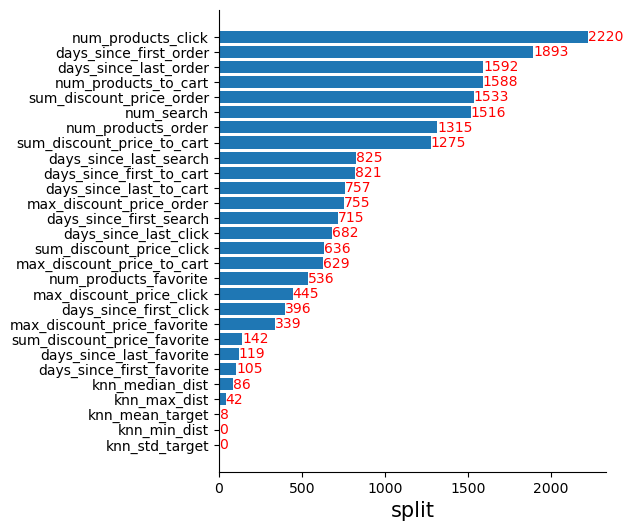

In [160]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [161]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_58384\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [162]:
id_ = 4
suf = 'search'


actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),


        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [163]:
df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

In [167]:
from local_utils import *

tr, val = get_split(df_pd, val_size=0.3)


tr_users = df_pd[df_pd['user_id'].isin(tr['user_id'])]
val_users = df_pd[df_pd['user_id'].isin(val['user_id'])]

train_with_knn, test_with_knn = add_knn_features(
    tr_users,
    val_users,
    features = cols,
    target='target',
    n_neighbors = 5
)

df_pd = pd.concat([train_with_knn, test_with_knn], axis=1)

KeyError: 'knn_mean_target'

In [164]:
from local_utils import *

df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

KeyError: "['knn_mean_target', 'knn_std_target', 'knn_median_dist', 'knn_min_dist', 'knn_max_dist'] not in index"

In [ ]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.165930
1,9852,0.755619
2,10206,0.217591
3,11317,0.216803
4,13289,0.585204
...,...,...
2068419,11157283,0.226435
2068420,11160395,0.143191
2068421,11165052,0.604149
2068422,11168218,0.484989


In [ ]:
df_pd[['user_id', 'predict']].to_csv('knn_res.csv', index=False)